<a href="https://colab.research.google.com/github/ZeyadSabbah/TrivagoRecommenderSystem/blob/master/TrivagoEDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mounting to Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My Drive/Trivago/

/content/drive/My Drive/Trivago


# Loading Libraries & Datasets

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
item_metadata_filepath = './Datasets/raw_data/item_metadata.csv'
submission_popular_filepath = './Datasets/raw_data/submission_popular.csv'
train_filepath = './Datasets/raw_data/train.csv'
test_filepath = './Datasets/raw_data/test.csv'

submission_popular = pd.read_csv(submission_popular_filepath)
item_metadata = pd.read_csv(item_metadata_filepath)
train = pd.read_csv(train_filepath)
test = pd.read_csv(test_filepath)

# Understanding Different Datasets

## train

In [5]:
train.shape

(15932992, 12)

In [6]:
train.dtypes

user_id            object
session_id         object
timestamp           int64
step                int64
action_type        object
reference          object
platform           object
city               object
device             object
current_filters    object
impressions        object
prices             object
dtype: object

In [7]:
train.tail()

,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices
15932987,ZYNMLE3MV3LK,62728015bec05,1541544490,15,interaction item image,6617798,PT,"Paris, France",desktop,NaN,NaN,NaN
15932988,ZYNMLE3MV3LK,62728015bec05,1541544491,16,clickout item,6617798,PT,"Paris, France",desktop,Focus on Distance,6617798|1263420|9567886|1161323|149768|1890735...,58|96|55|75|90|60|233|104|150|145|328|207|150|...
15932989,ZYNMLE3MV3LK,62728015bec05,1541544540,17,clickout item,2712342,PT,"Paris, France",desktop,Focus on Distance,6617798|1263420|9567886|1161323|149768|1890735...,58|96|55|75|90|60|233|104|150|145|328|207|150|...
15932990,ZYNMLE3MV3LK,62728015bec05,1541544967,18,change of sort order,interaction sort button,PT,"Paris, France",desktop,NaN,NaN,NaN
15932991,ZYNMLE3MV3LK,62728015bec05,1541544973,19,clickout item,1161323,PT,"Paris, France",desktop,Focus on Distance,6617798|1263420|9567886|1161323|149768|1890735...,58|96|55|75|90|60|233|104|150|145|328|207|150|...


Final Click-out in each session represented in action_type attribute is the most important step for the click through rate. Any session can contain zero, one, or many click-outs, though.Trivago concentrates at this for the profit calculation. All features required to be engineered is based on predicting the final click out action.  
Each user has an id, each user can have one or more separated sessions. There is a recorded timestamp for each step the user is taking on the website or on the app, and steps are counted in each session through the count going from one till the end when the user leaves the session.  
The step can be anything from checking a rating to viewing an image to changing an order of the list to other actions that has to do with items (accommodations).
Accommodations have ids shown in reference attribute, these accommodations are displayed to the user in the form of list, and the list can vary from just one item up to 25 items.  
The shown items are put in a string separated by a pipe in the impressions attribute, matching this order is the prices list separated by a pipe as well in the prices attribute. (These two attributes do not have a value unless the action_type attribute is 'clickout'.  
The platform attribute contains the location from where the user is checking the website or the app, while the city is the location where they are looking for the accommodation in, and device shows which device they are actually using.  
The current_filters attribute shows what the filters the user has specified in their search for the suitable accommodation to themselves.

## test

In [8]:
test.shape

(3782335, 12)

In [9]:
test.dtypes

user_id            object
session_id         object
timestamp           int64
step                int64
action_type        object
reference          object
platform           object
city               object
device             object
current_filters    object
impressions        object
prices             object
dtype: object

In [10]:
test.tail(1)

,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices
3782334,ZZCM39YKI3NR,6226bde1465e7,1541601178,1,clickout item,NaN,IT,"Dublin, Ireland",mobile,NaN,46149|109974|46119|8333280|12455|1185556|84002...,138|138|156|153|128|202|145|137|105|68|133|167...


The NaN value shown in reference is actually the label hidden away. That represents what needs to be predicted or in another way that's what needs to be put in a list and Trivago is considered to do better if this item was on the top of the list provided to the user.

## submission_popular

This is the form on how the test set predictions should be submitted.

In [11]:
submission_popular.head(2)

,user_id,session_id,timestamp,step,item_recommendations
0,000324D9BBUC,89643988fdbfb,1541593942,10,924795 106315 1033140 119494 101758 903037 105...
1,0004Q49X39PY,9de47d9a66494,1541641157,1,3505150 3812004 2227896 2292254 3184842 222702...


Taking a session as an example to understand what is being represented in the submission_popular dataset in relation with test set.

In [12]:
test[test.session_id=='9de47d9a66494']

,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices
1030763,0004Q49X39PY,9de47d9a66494,1541641157,1,clickout item,NaN,PH,"Iloilo City, Philippines",mobile,NaN,2213014|3184842|10213134|4504242|4486372|38120...,53|40|112|57|76|29|42|37|66|66|26|43|28|46|28|...


If we take a look at the impressions of this session at the test set, and the item_recommendations in submission_popular, we will find that they are the same items, only with difference in the order and also the separator.

In [13]:
test_impressions = test[test.session_id=='9de47d9a66494'].impressions.values[0].split('|')
item_recommendations = submission_popular[submission_popular.session_id=='9de47d9a66494'].item_recommendations.values[0].split(' ')

sorted(test_impressions) == sorted(item_recommendations)

True

## item_metadata

In [14]:
item_metadata.head()

,item_id,properties
0,5101,Satellite TV|Golf Course|Airport Shuttle|Cosme...
1,5416,Satellite TV|Cosmetic Mirror|Safe (Hotel)|Tele...
2,5834,Satellite TV|Cosmetic Mirror|Safe (Hotel)|Tele...
3,5910,Satellite TV|Sailing|Cosmetic Mirror|Telephone...
4,6066,Satellite TV|Sailing|Diving|Cosmetic Mirror|Sa...


The item_metadata set contains the properties for each item id (mentioned before in reference attributes in other datasets). The properties are also separated by a pipe and in the string format.

# Research Questions

**What is the timeline of the training and test sets?**

In [15]:
from datetime import datetime

latest_timestamp = train.timestamp.max()
earliest_timestamp = train.timestamp.min()
print(datetime.fromtimestamp(latest_timestamp) - datetime.fromtimestamp(earliest_timestamp))

5 days, 23:59:51


In [16]:
latest_timestamp = test.timestamp.max()
earliest_timestamp = test.timestamp.min()
print(datetime.fromtimestamp(latest_timestamp) - datetime.fromtimestamp(earliest_timestamp))

1 day, 23:59:52


The training data is gathered over 6 days, while the test data is over 2 days.

**Which days, month, and year this data is gathered over?**

In [17]:
latest_timestamp = train.timestamp.max()
earliest_timestamp = train.timestamp.min()

latest_date = datetime.fromtimestamp(latest_timestamp)
earliest_date = datetime.fromtimestamp(earliest_timestamp)

print(earliest_date)
print(latest_date)

2018-11-01 00:00:08
2018-11-06 23:59:59


In [18]:
latest_timestamp = test.timestamp.max()
earliest_timestamp = test.timestamp.min()

latest_date = datetime.fromtimestamp(latest_timestamp)
earliest_date = datetime.fromtimestamp(earliest_timestamp)

print(earliest_date)
print(latest_date)

2018-11-07 00:00:07
2018-11-08 23:59:59


The train and test sets are over 8 consecutive days.

**What days of the week for the train and test sets?**

In [19]:
import calendar

latest_timestamp = train.timestamp.max()
earliest_timestamp = train.timestamp.min()

latest_date = datetime.fromtimestamp(latest_timestamp)
earliest_date = datetime.fromtimestamp(earliest_timestamp)

first_day = calendar.day_name[earliest_date.weekday()]
last_day = calendar.day_name[latest_date.weekday()]
print(first_day)
print(last_day)

Thursday
Tuesday


In [20]:
latest_timestamp = test.timestamp.max()
earliest_timestamp = test.timestamp.min()

latest_date = datetime.fromtimestamp(latest_timestamp)
earliest_date = datetime.fromtimestamp(earliest_timestamp)

first_day = calendar.day_name[earliest_date.weekday()]
last_day = calendar.day_name[latest_date.weekday()]
print(first_day)
print(last_day)

Wednesday
Thursday


**What is the distribution of the number of steps in sessions?**

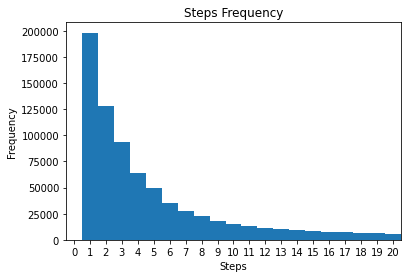

In [21]:
bin_size = 1
sessions_steps = train.groupby('session_id', sort=False).timestamp.count()
bin_edges = np.arange(0, sessions_steps.max() + bin_size, bin_size)
x_locs = np.arange(0, 21, 1) + 0.5
x_labels = np.arange(0, 21, 1)

plt.hist(sessions_steps, bins=bin_edges)
plt.xticks(x_locs, x_labels)
plt.xlim([0, 21])
plt.xlabel('Steps')
plt.ylabel('Frequency')
plt.title('Steps Frequency')
plt.show()

The number of steps is right skewed, an interesting observation is that there is actually many sessions with only one step.

**What is the duration distribution of sessions?**

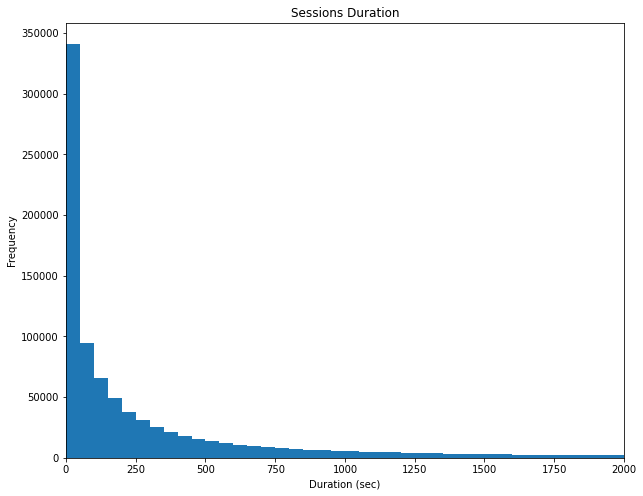

In [22]:
sessions_duration = train.groupby('session_id', sort=False).timestamp.max() - train.groupby('session_id', sort=False).timestamp.min()
bin_size = 50
bin_edges = np.arange(0, 2000 + bin_size, bin_size)

plt.figure(figsize=[10, 8])
plt.hist(sessions_duration, bins=bin_edges)
plt.xlim([0, 2000])
plt.xlabel('Duration (sec)')
plt.ylabel('Frequency')
plt.title('Sessions Duration')
plt.show()

The data is right skewed. Logarithmic transformation would be much of a help in this case.

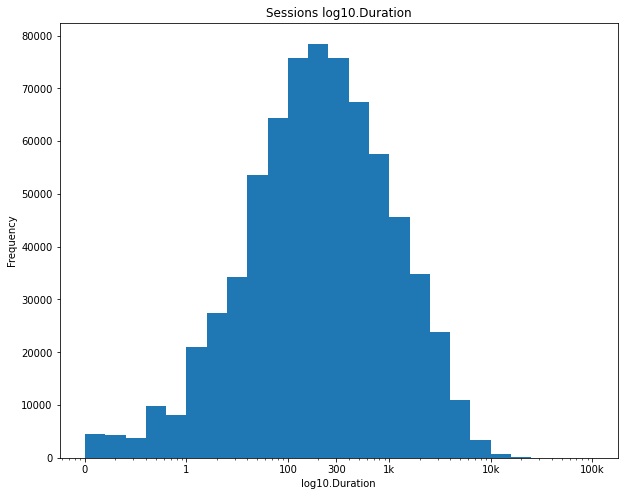

In [23]:
bin_size = 0.2
bin_edges = 10 ** np.arange(0, 5 + bin_size, bin_size)

plt.figure(figsize=[10, 8])
plt.hist(sessions_duration, bins=bin_edges)
x_locs = [1e0, 1e1, 1e2, 3e2, 1e3, 1e4, 1e5]
x_labels = ['0', '1', '100', '300', '1k', '10k', '100k']
plt.xscale('log')
plt.xticks(x_locs, x_labels)
plt.xlabel('log10.Duration')
plt.ylabel('Frequency')
plt.title('Sessions log10.Duration')
plt.show()

**What is the action distribution?**

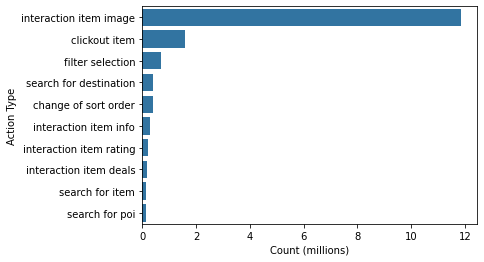

In [24]:
action_type_order = train.action_type.value_counts().index
base_color = sns.color_palette()[0]
sns.countplot(data=train, y='action_type', color=base_color, order=action_type_order)
x_locs = [0, 0.2e7, 0.4e7, 0.6e7, 0.8e7, 1e7, 1.2e7]
x_labels = ['0', '2', '4', '6', '8', '10', '12']
plt.xlabel('Count (millions)')
plt.ylabel('Action Type')
plt.xticks(x_locs, x_labels)
plt.show()

It seems like users like to check for the images of the accommodations the most. Disregarding the 'interaction item image' to check the other attributes values. 'clickout item' comes second.

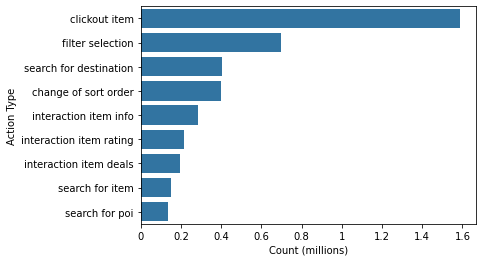

In [25]:
action_type_order = train[train.action_type!='interaction item image'].action_type.value_counts().index
base_color = sns.color_palette()[0]
sns.countplot(data=train, y='action_type', color=base_color, order=action_type_order)
x_locs = [0, 0.2e6, 0.4e6, 0.6e6, 0.8e6, 1e6, 1.2e6, 1.4e6, 1.6e6]
x_labels = ['0', '0.2', '0.4', '0.6', '0.8', '1', '1.2', '1.4', '1.6']
plt.xlabel('Count (millions)')
plt.ylabel('Action Type')
plt.xticks(x_locs, x_labels)
plt.show()

**What is the distribution of the platforms used?**

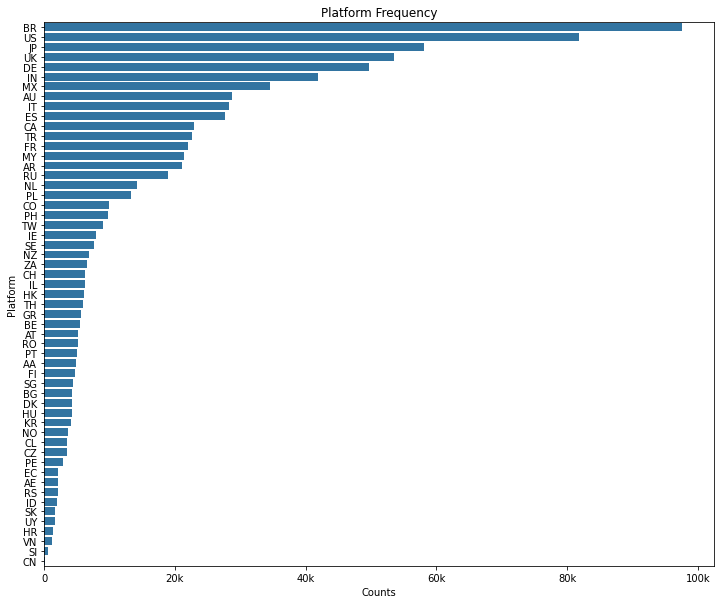

In [26]:
clickout_df = train[train.action_type=='clickout item'].groupby('session_id', sort=False).tail(1)
base_color = sns.color_palette()[0]
platform_order = clickout_df.platform.value_counts().index
plt.figure(figsize=[12, 10])
sns.countplot(data=clickout_df, y='platform', color=base_color, order=platform_order)
plt.title('Platform Frequency')
plt.xlabel('Counts')
plt.ylabel('Platform')
x_locs = np.arange(0, 1e5 + 1, 2e4)
x_labels = ['0', '20k', '40k', '60k', '80k', '100k']
plt.xticks(x_locs, x_labels)
plt.show()

This shows that the highest number of users are from Brazil, comes second United States, and so on.

**What is the distribution of the worlds' accommodations selected?**

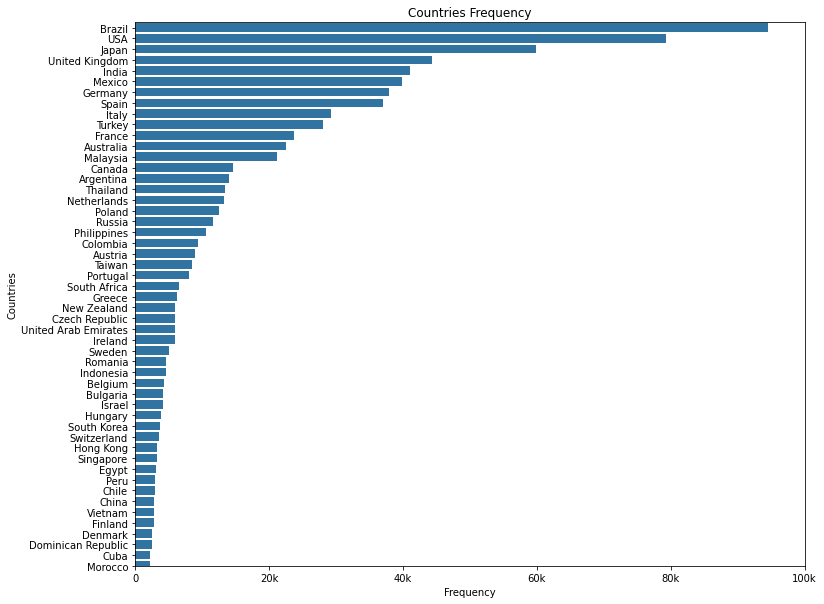

In [27]:
countries = clickout_df.city.apply(lambda x: x.split(',')[1]).apply(lambda x: x.strip())
countries_order = countries.value_counts().index

plt.figure(figsize=[12, 10])
sns.countplot(y=countries, color=base_color, order=countries_order)
plt.ylim(50)
plt.xlabel('Frequency')
plt.ylabel('Countries')
plt.title('Countries Frequency')
x_locs = np.arange(0, 1e5 + 1, 2e4)
x_labels = ['0', '20k', '40k', '60k', '80k', '100k']
plt.xticks(x_locs, x_labels)
plt.show()

The highest countries in terms of accommodations' booking are Brazil, then United Kingdom, and so on.

**What is the traffic across the week?**

In [28]:
clickout_df['date_time'] = clickout_df.timestamp.apply(lambda x: datetime.fromtimestamp(x))
clickout_df['day_of_week'] = clickout_df.date_time.apply(lambda x: calendar.day_name[x.weekday()])
clickout_df.head(1)

,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices,date_time,day_of_week
15,00RL8Z82B2Z1,aff3928535f48,1541038485,16,clickout item,1257342,AU,"Sydney, Australia",mobile,NaN,55109|129343|54824|2297972|109014|1257342|1031...,162|25|150|143|101|49|118|131|18|100|101|143|5...,2018-11-01 02:14:45,Thursday


In [29]:
day_of_week_order = ['Thursday', 'Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday']
week = pd.api.types.CategoricalDtype(categories=day_of_week_order, ordered=True)
clickout_df.groupby('day_of_week').session_id.count()

day_of_week
Friday      132126
Monday      146582
Saturday    125188
Sunday      140455
Thursday    137190
Tuesday     145301
Name: session_id, dtype: int64

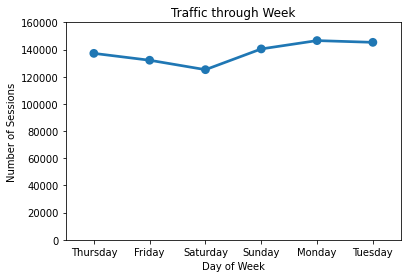

In [30]:
day_of_week_order = ['Thursday', 'Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday']
sessions_day = clickout_df.groupby('day_of_week').session_id.count()
sns.pointplot(x=sessions_day.index, y=sessions_day.values, order=day_of_week_order)
plt.ylim([0, 160000])
plt.ylabel('Number of Sessions')
plt.xlabel('Day of Week')
plt.title('Traffic through Week')
plt.show()

Users might be more active, and there might be more traffic at the start of the week going on.

**What is the relationship between number of steps and duration in the sessions?**

In [31]:
sessions_duration = train.groupby('session_id', sort=False).timestamp.max() - \
                    train.groupby('session_id', sort=False).timestamp.min()
sessions_duration = sessions_duration.reset_index().rename(columns={'timestamp':'duration'})
clickout_df = clickout_df.merge(sessions_duration, on='session_id', how='left')
clickout_df.head(1)

,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices,date_time,day_of_week,duration
0,00RL8Z82B2Z1,aff3928535f48,1541038485,16,clickout item,1257342,AU,"Sydney, Australia",mobile,NaN,55109|129343|54824|2297972|109014|1257342|1031...,162|25|150|143|101|49|118|131|18|100|101|143|5...,2018-11-01 02:14:45,Thursday,1025


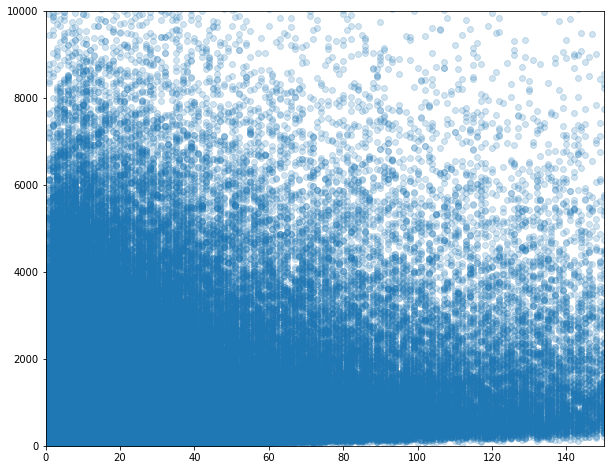

In [32]:
plt.figure(figsize=[10, 8])
plt.scatter(clickout_df.step, clickout_df.duration, alpha=0.2)
plt.xlim([0, 150])
plt.ylim([0, 10000]);

In [33]:
len(clickout_df)

826842

There is an over-plotting. I tried to overcome it with setting the alpha parameter to a low number, but it did not do a great job.  
Next approach will be sampling as there is more than 800k observations.

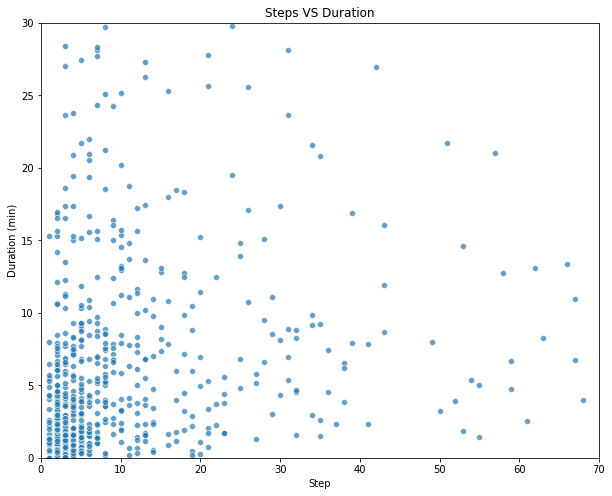

In [34]:
np.random.seed(42)
clickout_df_sample = clickout_df.sample(1000)
plt.figure(figsize=[10, 8])
sns.scatterplot(clickout_df_sample.step, clickout_df_sample.duration/(60), alpha=0.7)
plt.xlim([0, 70])
plt.ylim([0, 30])
plt.xlabel('Step')
plt.ylabel('Duration (min)')
plt.title('Steps VS Duration')
plt.show()

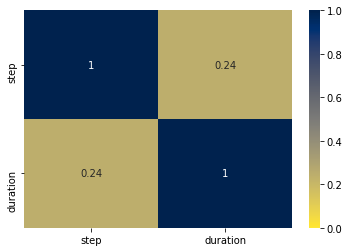

In [35]:
sns.heatmap(clickout_df[['step', 'duration']].corr(), cmap='cividis_r', annot=True, vmin=0);

**How good is Trivago's Recommender Engine doing?**

In [36]:
def get_list(List):
  items_list = List.split('|')
  return items_list

def get_rank(reference, List):
  ''' Function that gets the rank of user's item selection '''
  try:
    rank = get_list(List).index(reference) + 1
  except:
    rank = 0
  return rank

In [37]:
clickout_df['rank'] = clickout_df.apply(lambda x: get_rank(x.reference, x.impressions), axis=1).values

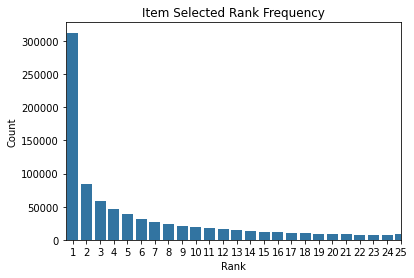

In [38]:
sns.countplot(data=clickout_df, x='rank', color=base_color)
plt.xlim([0.5, 25])
plt.xlabel('Rank')
plt.ylabel('Count')
plt.title('Item Selected Rank Frequency');

In [39]:
round(len(clickout_df[clickout_df['rank']==1])/len(clickout_df), 3)

0.378

It seems that Trivago's Recommender Engine is doing a good job since around 38% of the users are actually selecting the first item which is on the top of the list.

**Do devices play a role in the rank of item selected?**

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:723: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


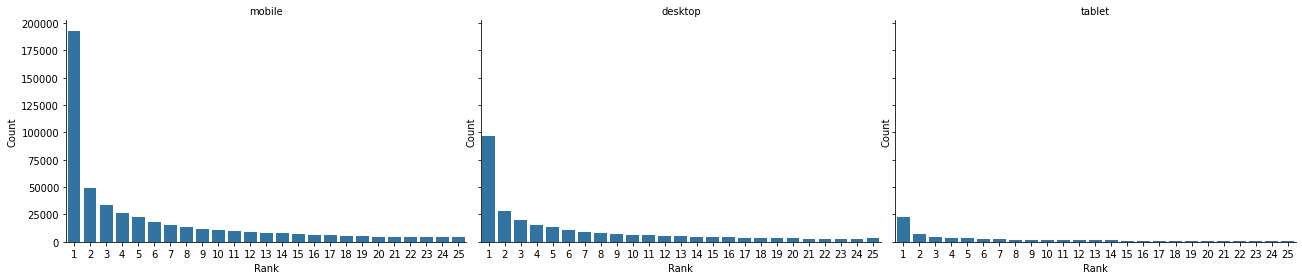

In [40]:
g = sns.FacetGrid(clickout_df, col='device', height=4, aspect=1.5)
g.map(sns.countplot, 'rank')
g.set(xlim=[0.5, 25.5], xlabel='Rank', ylabel='Count')
g.set_titles('{col_name}');

Relative Frequency of the above graphs is required as this piece of information is still hidden within the common axes of the 3 plots.

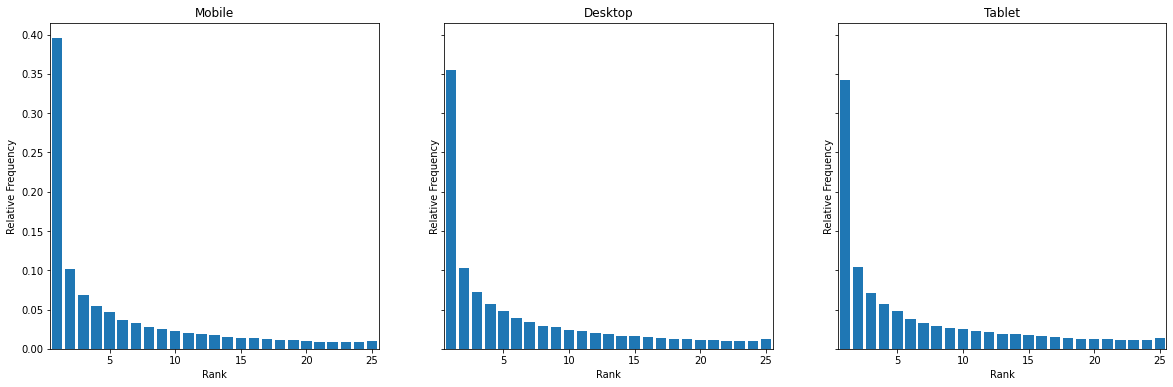

In [41]:
mobile_rf = clickout_df[clickout_df.device=='mobile']['rank'].value_counts()/len(clickout_df[clickout_df.device=='mobile'])
desktop_rf = clickout_df[clickout_df.device=='desktop']['rank'].value_counts()/len(clickout_df[clickout_df.device=='desktop'])
tablet_rf = clickout_df[clickout_df.device=='tablet']['rank'].value_counts()/len(clickout_df[clickout_df.device=='tablet'])

fig, axes = plt.subplots(1, 3, sharey=True, figsize=[20, 6])
dfs = [mobile_rf, desktop_rf, tablet_rf]
names = ['Mobile', 'Desktop', 'Tablet']
for i in range(3):
  plt.sca(axes[i])
  plt.bar(dfs[i].index, dfs[i].values)
  plt.xlim([0.5, 25.5])
  plt.xlabel('Rank')
  plt.ylabel('Relative Frequency')
  plt.title(names[i])

It seems there is no difference in the distributions of the three devices, but in order to be more confident about that, bootstrapping sampling technique can be used to simulate the null hypothesis of them being equal.  
The reason why I am focusing on this point is that the display on each screen of these devices is different, for example the mobile may be able to show only 3 items, while the tablet 4, and the desktop 5. This might affect the user's decision in selecting the accommodation.

**What is the selected items' prices distribution?**

In [42]:
def get_price(List, rank):
  try:
    items_list = List.split('|')
    price = items_list[rank]
  except:
    price = np.nan
  return price

In [43]:
clickout_df['price'] = clickout_df.apply(lambda x: get_price(x.prices, x['rank'] - 1), axis=1).values

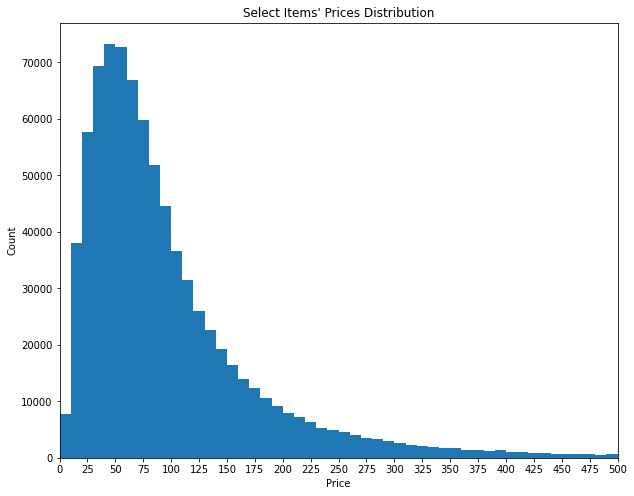

In [48]:
clickout_df['price'] = clickout_df['price'].astype(int)

plt.figure(figsize=[10, 8])
bin_edges = np.arange(0, 510, 10)
plt.hist(clickout_df['price'], bins=bin_edges)
plt.xlim([0, 500])
plt.xticks([])
x_ticks = np.arange(0, 525, 25)
plt.xticks(x_ticks, x_ticks)
plt.xlabel('Price')
plt.ylabel('Count')
plt.title("Select Items' Prices Distribution");

**What is all shown accomodations' prices distribution?**

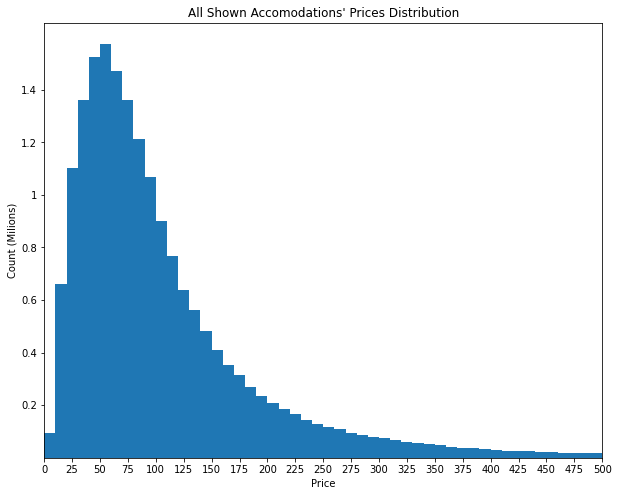

In [49]:
all_accomodations_prices = clickout_df.prices.apply(lambda x: x.split('|')).explode()
all_accomodations_prices = all_accomodations_prices.astype(int)

plt.figure(figsize=[10, 8])
bin_edges = np.arange(0, 510, 10)
plt.hist(all_accomodations_prices, bins=bin_edges)
plt.xlim([0, 500])
plt.xticks([])
x_ticks = np.arange(0, 525, 25)
plt.xticks(x_ticks, x_ticks)
plt.xlabel('Price')
plt.ylabel('Count (Milions)')
y_locs = [0.2e6, 0.4e6, 0.6e6, 0.8e6, 1e6, 1.2e6, 1.4e6]
y_labels = [0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4]
plt.yticks(y_locs, y_labels)
plt.title("All Shown Accomodations' Prices Distribution");

Distributions of the items selected and all items shown prices are very close. It shows that the accommodations with low prices are higher in number than that with high prices (regardless of the number of nights or the number of rooms will be reserved as for each user's selection of the duration or the number of rooms or any other thing is being applied to all the accommodations provided for the user.)

**What is the relation between Rank and Average Step?**   

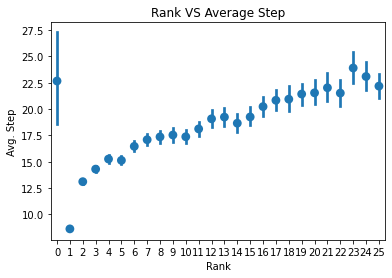

In [46]:
sns.pointplot(data=clickout_df, x='rank', y='step', linestyles='')
plt.xlabel('Rank')
plt.ylabel('Avg. Step')
plt.title('Rank VS Average Step')
plt.show()

In general, this graph shows that the more the user takes step, the more likely they end up with an item that is not in the top of the list.  
The zero value of rank indicates that the choice of the user was not in the list in the first place. There might be a technical explanation for that such as the user was viewing from different tabs and the clickout was made from the tab that did no include the item.  
The large whisker in Zero means that there is no enough data available, for this point. On the other hand, the whisker keeps getting larger going from rank 1 to 25, that's because of the distribution of the data having rank 1 on the top for example.

**What is the relation between Rank and Average Step in the terms of devices?**

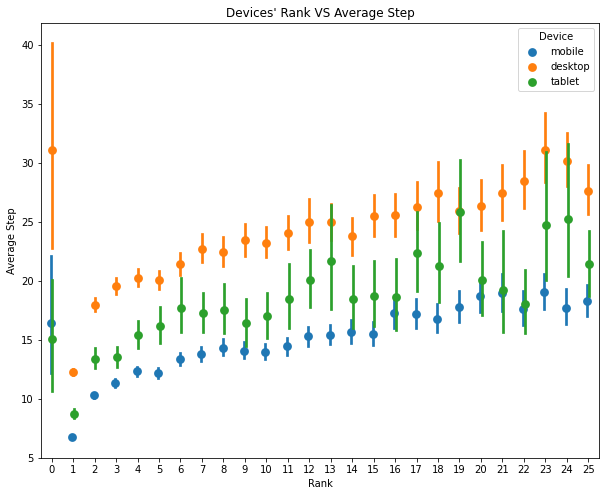

In [47]:
plt.figure(figsize=[10, 8])
sns.pointplot(data=clickout_df, x='rank', y='step', hue='device', linestyles='', dodge=True)
plt.xlabel('Rank')
plt.ylabel('Average Step')
plt.legend(title='Device')
plt.title("Devices' Rank VS Average Step")
plt.show()

The relationship seems to be the same, only shifted when it comes to the device used. The desktop user makes more steps than the tablet and mobile user for the same rank, and the tablet user makes more steps than mobile user for the same rank.  
One explanation to this graph can be user feels more comfortable surfing the website on the desktop and takes their times checking accommodations than on smaller devices.

**What are the distributions of the mean price of the all show prices vs the selected prices?**

In [50]:
clickout_df['prices_mean'] = clickout_df.prices.apply(lambda x: x.split('|'))\
                                               .apply(lambda x: list(map(int, x)))\
                                               .apply(lambda x: np.array(x).mean())\
                                               .apply(lambda x: np.floor(x))

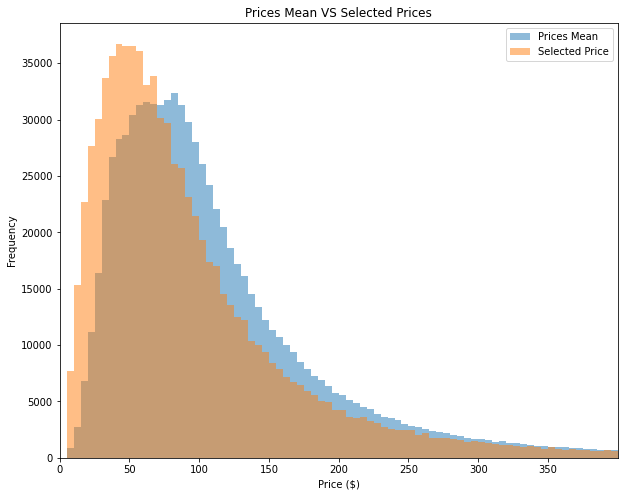

In [51]:
bins = np.arange(0, 450, 5)
plt.figure(figsize=[10, 8])
plt.hist(clickout_df.prices_mean, bins=bins, alpha=0.5, label='Prices Mean')
plt.hist(clickout_df.price.astype(int), bins=bins, alpha=0.5, label='Selected Price')
plt.xlim([0, 400])
x_ticks = np.arange(0, 400, 50)
plt.xticks(x_ticks, x_ticks)
plt.title('Prices Mean VS Selected Prices')
plt.xlabel('Price ($)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

The distribution of the prices of selected items by the user is shifted litle bit to the left and has higher height than that of the distribution of the mean of the prices. That shows that users in general would pick an item with price less than the mean price of all items shown to them.

**What are the distributions of the median of all prices shown to the users vs the selected prices?**

In [52]:
clickout_df['prices_median'] = clickout_df.prices.apply(lambda x: x.split('|'))\
                                          .apply(lambda x: list(map(int, x)))\
                                          .apply(lambda x: np.median(np.array(x)))

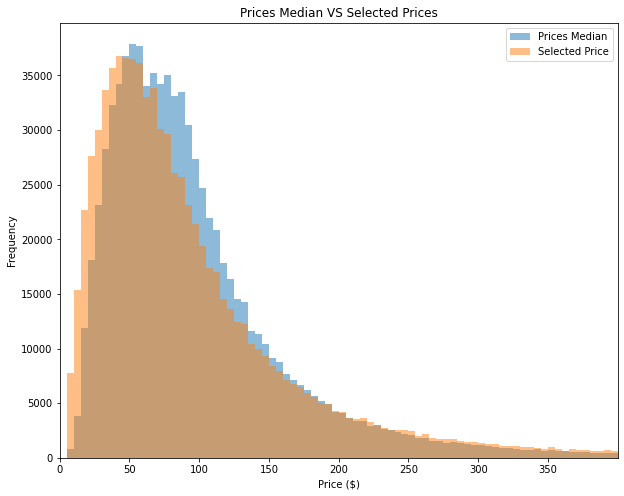

In [53]:
bins = np.arange(0, 450, 5)
plt.figure(figsize=[10, 8])
plt.hist(clickout_df.prices_median, bins=bins, alpha=0.5, label='Prices Median')
plt.hist(clickout_df.price.astype(int), bins=bins, alpha=0.5, label='Selected Price')
plt.xlim([0, 400])
x_ticks = np.arange(0, 400, 50)
plt.xticks(x_ticks, x_ticks)
plt.title('Prices Median VS Selected Prices')
plt.xlabel('Price ($)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

The distribution of the selected item price is still shifted to the left and that supports the fact that users would go for lower prices than the average in general.

**What is the relationship between rank and price rank?**
Note: Price rank is the rank of the item when all the items in the list are sorted in an ascending order.

In [55]:
clickout_df['sorted_prices'] = clickout_df.prices.apply(lambda x: x.split('|'))\
                                                 .apply(lambda x: list(map(int, x)))\
                                                 .apply(lambda x: sorted(x))

In [56]:
def get_price_rank(price, price_list):
  ''' Function that gets the price rank of an item when all items in the same list are sorted in ascending order '''
  try:
    rank = price_list.index(price) + 1
  except:
    rank = 0
  return rank

In [57]:
clickout_df['price_rank'] = clickout_df[['price', 'sorted_prices']].apply(lambda x: get_price_rank(x.price, x.sorted_prices), axis=1)

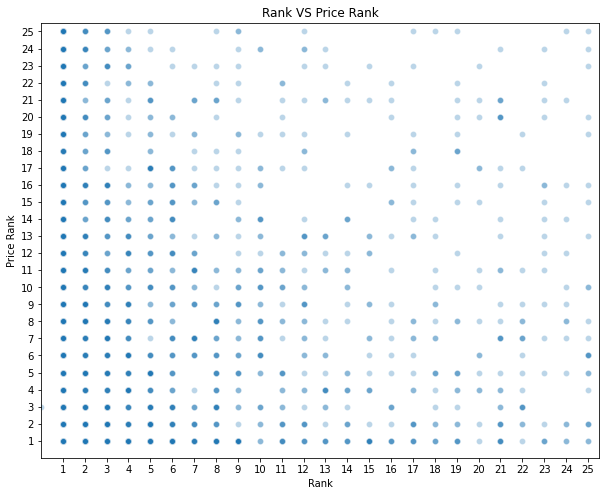

In [59]:
np.random.seed(42)
clickout_df_sample = clickout_df.sample(2000)

plt.figure(figsize=[10, 8])
sns.scatterplot(clickout_df_sample['rank'], clickout_df_sample['price_rank'], alpha=0.3)
x_y_ticks = np.arange(1, 25 + 1, 1)
plt.yticks(x_y_ticks, x_y_ticks)
plt.xticks(x_y_ticks, x_y_ticks)
plt.xlabel('Rank')
plt.ylabel('Price Rank')
plt.title('Rank VS Price Rank')
plt.xlim([0, 25.5])
plt.ylim([0, 25.5]);

Although it is clear that the density seems to be heavier on the left bottom corner of the graph, and it might make an intuition of the presence of a correlation between the ranking, actually there is not. The fact that the ranking distribution is right skewed affects the graph over here, and that's it.

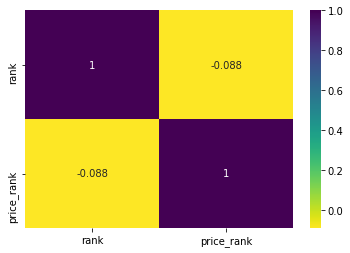

In [60]:
sns.heatmap(clickout_df_sample[['rank', 'price_rank']].corr(), annot=True, cmap='viridis_r');

The Pearson correlation factor assures that there is no relationship at all between both ranking.